In [1]:
import torch 
from unet import UNet
from medical_dataset import MedicalDataset
import torch.optim as optim
from loss import Active_Contour_Loss
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import numpy as np
from utilities import *

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
cust_transforms = [
    transforms.Resize((256,256)),
    #transforms.ColorJitter(0.5,0.5),
    #transforms.GaussianBlur(3, sigma=(0.1, 2.0)),
]

In [4]:
label = 1
D_train = MedicalDataset(label, "data_train", cust_transforms)
D_val = MedicalDataset(label, "data_validation")
D_test = MedicalDataset(label, "data_test")

In [5]:
train_loader = torch.utils.data.DataLoader(
    D_train, batch_size=5, shuffle=True
)

val_loader = torch.utils.data.DataLoader(
    D_val, batch_size=5, shuffle=False
)

In [6]:
model = UNet(1,1)
model.to(device)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
 

In [7]:
optimizer = optim.Adam(
    model.parameters(),
    lr=2*10**-5
)

In [8]:
def CE_loss(y_pred, y_true):
    eps = 10**-6
    loss = y_true*torch.log(y_pred*(1-eps)+eps) + (1-y_true)*torch.log((1-y_pred)*(1-eps)+eps)
    return -loss.mean()

def MSE_loss(y_pred, y_true):
    return ((y_pred-y_true)**2).mean()

In [9]:
def train(model, optimizer, epoch, loader, loss_func, sigmoid=False):
    model.train()
    losses=[]

    for batch_idx, (data, target) in enumerate(loader):
        if device=="cuda":
            data, target = data.cuda(), target.cuda()
        optimizer.zero_grad()
        output = model(data)
        if sigmoid:
            output = torch.sigmoid(output)
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        if batch_idx%20==0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}".format(
                    epoch,
                    batch_idx * len(data),
                    len(loader.dataset),
                    100.0 * batch_idx / len(loader),
                    loss.data.item(),
                ),
                flush=True,
            )
    return losses

In [10]:
losses = []
evalu = []

In [11]:
for i in range(16):
    losses += train(model, optimizer, i, train_loader, Active_Contour_Loss, False)
    evalu.append(evaluate(model, val_loader, False))
    print(evalu)

RuntimeError: CUDA out of memory. Tried to allocate 40.00 MiB (GPU 0; 7.77 GiB total capacity; 1.01 GiB already allocated; 37.25 MiB free; 1.05 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

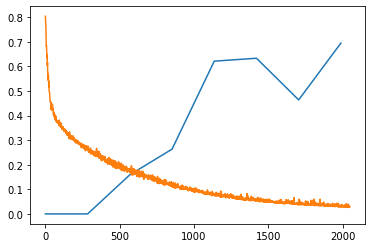

In [12]:
plt.plot(np.linspace(0,1242/5*len(evalu),len(evalu)), evalu)
plt.plot(losses)
model.save

In [13]:
torch.save(model.state_dict(), 'models/unet1_CE.pt')

In [77]:
#model.load_state_dict(torch.load('models/unetAC.pt'))

100%|███████████████████████████████████████████| 56/56 [00:04<00:00, 13.32it/s]


tensor(0.7772, device='cuda:0')

In [50]:
x = next(iter(val_loader))

In [51]:
data, target = x[0].cuda(),  x[1].cuda()

In [52]:
model.eval()
out = torch.sigmoid(model(data))>0.5

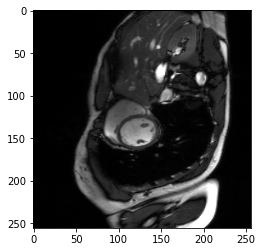

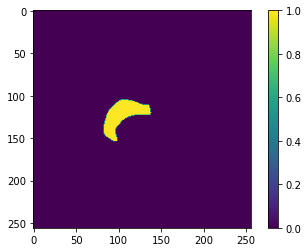

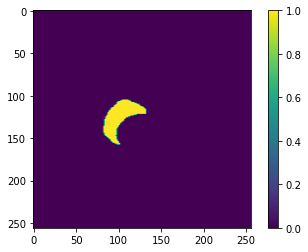

In [53]:
index = 2

plt.imshow(data[index, 0].cpu().detach().numpy(), cmap='gray')
plt.show()

plt.imshow(out[index,0].cpu().detach().numpy())
plt.colorbar()
plt.show()


plt.imshow(target[index,0].cpu().detach().numpy())
plt.colorbar()
plt.show()

In [7]:

def evaluate_rec(model_parse, sigmoid=False):
    model = UNet(1,1)
    model.to(device)
    for i in range(1,4):
        D_val = MedicalDataset(i, "data_validation")
        val_loader = torch.utils.data.DataLoader(
            D_val, batch_size=5, shuffle=False
        )
        model.load_state_dict(torch.load(model_parse.format(i)))
        model.eval()
        print(evaluate(model, val_loader, sigmoid).item())
        
evaluate_rec('models/unet{}_AC.pt')

0.6696599721908569
0.738817572593689
0.8192746043205261


In [55]:
from scipy.spatial.distance import directed_hausdorff

In [92]:
u = out[index,0].cpu().detach().numpy()


In [80]:
directed_hausdorff(v,u)

(2.4244442017707892, 156, 247)

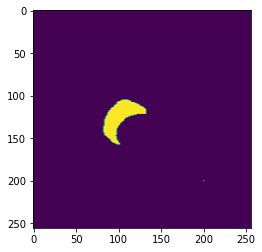

In [83]:
plt.imshow(v)

In [7]:
param_size = 0
for param in model.parameters():
    param_size += param.nelement() * param.element_size()
buffer_size = 0
for buffer in model.buffers():
    buffer_size += buffer.nelement() * buffer.element_size()

size_all_mb = (param_size + buffer_size) / 1024**2
print('model size: {:.3f}MB'.format(size_all_mb))

model size: 5.323MB
